# CNN for AED with Keras/TensorFlow

Date: November 6, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music

## Preparing data set for training CNN

## Preparing data set for CNN

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_FOLDER = '/content/gdrive/My Drive/acoustic_event_detection/data/'
FILTERS=40
FILES = 100
TRAINING_FILES = 67
TEST_FILES = FILES - TRAINING_FILES

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os
import sklearn.preprocessing as pp

In [0]:
import glob
piano_files = glob.glob(DATA_FOLDER+'*piano*mel_spectrogram*.csv')
classical_guitar_files = glob.glob(DATA_FOLDER+'*classical_guitar*mel_spectrogram*.csv')
framenco_guitar_files = glob.glob(DATA_FOLDER+'*framenco_guitar*mel_spectrogram*.csv')
blues_harp_files = glob.glob(DATA_FOLDER+'*blues_harp*mel_spectrogram*.csv')
tin_whistle_files = glob.glob(DATA_FOLDER+'*tin_whistle*mel_spectrogram*.csv')
random.shuffle(piano_files)
random.shuffle(classical_guitar_files)
random.shuffle(framenco_guitar_files)
random.shuffle(blues_harp_files)
random.shuffle(tin_whistle_files)

In [0]:
TRAINING_SET_PIANO = piano_files[:TRAINING_FILES]
TRAINING_SET_CLASSICAL_GUITAR = classical_guitar_files[:TRAINING_FILES]
TRAINING_SET_FRAMENCO_GUITAR = framenco_guitar_files[:TRAINING_FILES]
TRAINING_SET_BLUES_HARP = blues_harp_files[:TRAINING_FILES]
TRAINING_SET_TIN_WHISTLE = tin_whistle_files[:TRAINING_FILES]

TEST_SET_PIANO = piano_files[TRAINING_FILES:FILES]
TEST_SET_CLASSICAL_GUITAR = classical_guitar_files[TRAINING_FILES:FILES]
TEST_SET_FRAMENCO_GUITAR = framenco_guitar_files[TRAINING_FILES:FILES]
TEST_SET_BLUES_HARP = blues_harp_files[TRAINING_FILES:FILES]
TEST_SET_TIN_WHISTLE = tin_whistle_files[TRAINING_FILES:FILES]

TRAINING_SET = [(TRAINING_SET_PIANO, 0),
                (TRAINING_SET_CLASSICAL_GUITAR, 1),
                (TRAINING_SET_FRAMENCO_GUITAR, 2),
                (TRAINING_SET_BLUES_HARP, 3),
                (TRAINING_SET_TIN_WHISTLE, 4)]

TEST_SET = [(TEST_SET_PIANO, 0),
            (TEST_SET_CLASSICAL_GUITAR, 1),
            (TEST_SET_FRAMENCO_GUITAR, 2),
            (TEST_SET_BLUES_HARP, 3),
            (TEST_SET_TIN_WHISTLE, 4)]

In [0]:
training_set = []
test_set = []

LENGTH=64

a1, a2 = 0,  FILTERS*64
b1, b2 = FILTERS*64, FILTERS*64*2
c1, c2 = FILTERS*64*2, FILTERS*64*3

for files, l in TRAINING_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = df[a1:a2]['magnitude'].values/128.0
        img2 = df[b1:b2]['magnitude'].values/128.0
        img3 = df[c1:c2]['magnitude'].values/128.0
        training_set.append((img1, l))
        training_set.append((img2, l))
        training_set.append((img3, l))
        
for files, l in TEST_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = df[a1:a2]['magnitude'].values/128.0
        img2 = df[b1:b2]['magnitude'].values/128.0
        img3 = df[c1:c2]['magnitude'].values/128.0
        test_set.append((img1, l))
        test_set.append((img2, l))
        test_set.append((img3, l))
                        
random.shuffle(training_set)
random.shuffle(test_set)

In [0]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*5*3, LENGTH, FILTERS, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*5*3, LENGTH, FILTERS, 1))
test_labels = np.array(test_labels, dtype='uint8')

### CNN model

In [7]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(LENGTH, FILTERS, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 40, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 10, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 5, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
__________

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Training CNN

In [9]:
from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

model.fit(train_data, train_labels, epochs=25)
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('test_acc:', test_acc)

Epoch 1/25
1005/1005 [==============================] - 19s 19ms/step - loss: 1.6292 - acc: 0.2368
Epoch 2/25
1005/1005 [==============================] - 20s 20ms/step - loss: 1.2183 - acc: 0.4826
Epoch 3/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.6855 - acc: 0.7075
Epoch 4/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.5747 - acc: 0.7781
Epoch 5/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.5000 - acc: 0.7970
Epoch 6/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.3104 - acc: 0.8786
Epoch 7/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.3452 - acc: 0.8577
Epoch 8/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.3166 - acc: 0.8826
Epoch 9/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.2516 - acc: 0.9055
Epoch 10/25
1005/1005 [==============================] - 19s 19ms/step - loss: 0.2683 - acc: 0.8915
Epoch 11/

## Confirmation

In [10]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(1005, 64, 40, 1)

In [11]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 64, 40, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 32, 20, 64) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 32, 20, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 16, 10, 128) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 16, 10, 256) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 8, 5, 256) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_1/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense_2/Relu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'dense_3/Softmax:0' shape=(?, 5) dtype=float32>]

In [12]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
activations[0][0,:,:,0].shape

(64, 40)

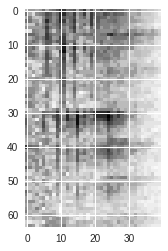

In [13]:
plt.imshow(test_data[12,:,:,0])

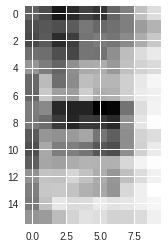

In [28]:
plt.imshow(activations[3][12,:,:,90])

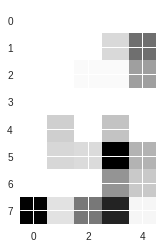

In [29]:
plt.imshow(activations[5][12,:,:,90])

In [30]:

(activations[9][:10]*100).astype(int)

array([[ 99,   0,   0,   0,   0],
       [ 60,  33,   5,   0,   0],
       [  0,  99,   0,   0,   0],
       [ 98,   1,   0,   0,   0],
       [  0,   0,   0,   0, 100],
       [  1,  98,   0,   0,   0],
       [  0,   0,   0,   0, 100],
       [ 93,   6,   0,   0,   0],
       [  0,   0,   0,   0, 100],
       [ 98,   1,   0,   0,   0]])

In [31]:
test_labels[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)